# Fundamentos de pricing: Elasticidades

Autor: Sergio Diaz Paredes

Contacto: [Linkedin](https://www.linkedin.com/in/sergio-diaz-paredes/)

## Paquetes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

## Cargar dataset

In [2]:
data = pd.read_csv("elasticidad.csv")
data['fecha'] = pd.to_datetime(data['fecha'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   fecha     574 non-null    datetime64[ns]
 1   precio    574 non-null    float64       
 2   cantidad  574 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 13.6 KB


## EDA

In [3]:
data.head()

,fecha,precio,cantidad
0,2018-01-01,7.8,516
1,2018-01-02,7.8,424
2,2018-01-03,7.8,334
3,2018-01-04,7.8,398
4,2018-01-05,7.8,454


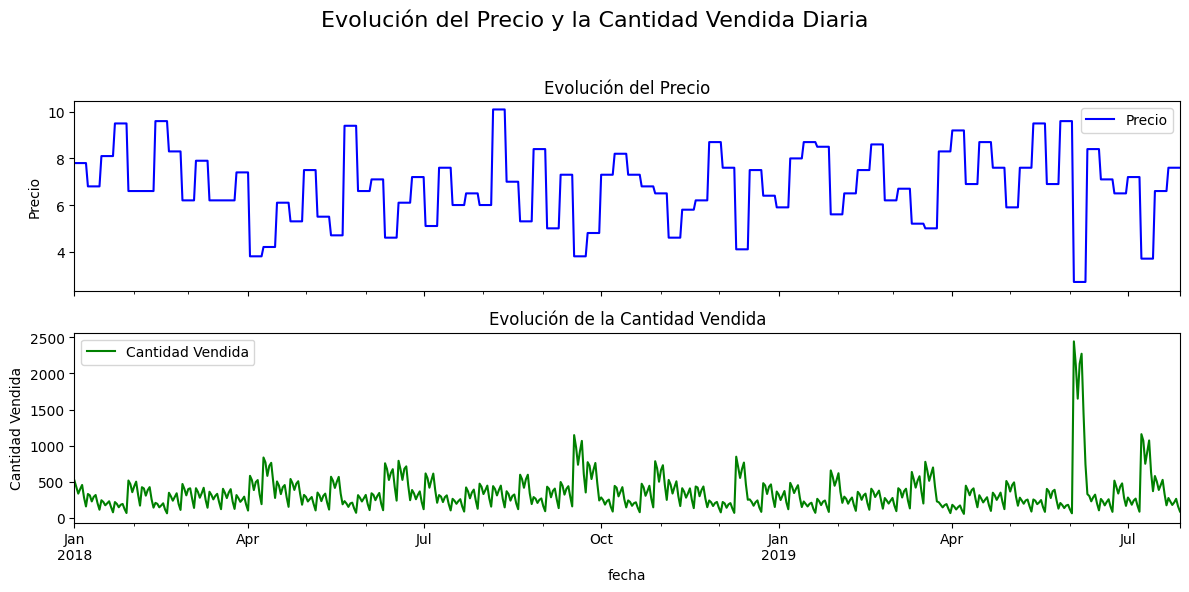

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

# Graficar el precio en el primer subgráfico
data.set_index('fecha')['precio'].plot(ax=axes[0], color='blue', label='Precio')
axes[0].set_title('Evolución del Precio')
axes[0].set_ylabel('Precio')
axes[0].legend()

# Graficar la cantidad vendida en el segundo subgráfico
data.set_index('fecha')['cantidad'].plot(ax=axes[1], color='green', label='Cantidad Vendida')
axes[1].set_title('Evolución de la Cantidad Vendida')
axes[1].set_ylabel('Cantidad Vendida')
axes[1].legend()

# Título principal
fig.suptitle('Evolución del Precio y la Cantidad Vendida Diaria', fontsize=16)

# Ajustar el espacio entre subgráficos
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Deja espacio para el título principal

plt.show()

## Estacionalidad Semanal

In [5]:
# Extraer el número del día de la semana (lunes=0, domingo=6)
data['dia_sem'] = data['fecha'].dt.weekday

<Axes: xlabel='dia_sem'>

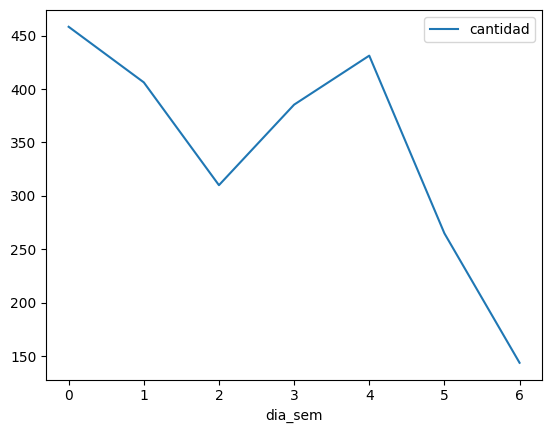

In [6]:
data.pivot_table(index='dia_sem',values='cantidad').plot()

<Axes: xlabel='dia_sem', ylabel='cantidad'>

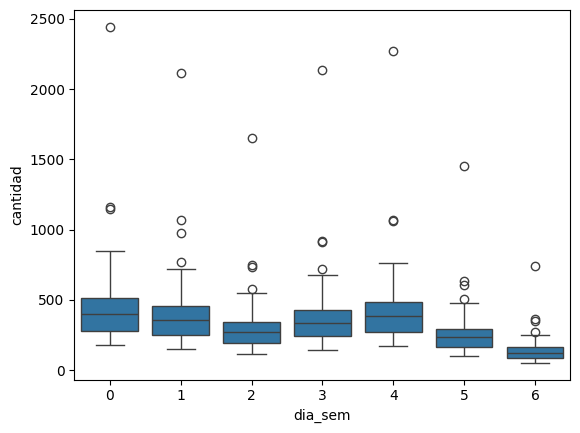

In [7]:
sns.boxplot(data,x='dia_sem',y='cantidad')

## Agregación semanal

In [8]:
# Crear un identificador de semana desde la primera fecha del dataset
data['semana'] = ((data['fecha'] - data['fecha'].min()).dt.days // 7)

In [9]:
# Agrupar por semana y calcular las métricas necesarias
weekly_data = data.groupby('semana').agg(
    cantidad=('cantidad', 'sum'),
    precio=('precio', 'mean')
)
weekly_data.head()

,cantidad,precio
semana,,
0,2560,7.8
1,1780,6.8
2,1282,8.1
3,1110,9.5
4,2760,6.6


In [10]:
# Crear una columna opcional para identificar la semana con la fecha inicial de cada grupo
weekly_data['fecha_inicio_semana'] = data.groupby('semana')['fecha'].min().values

In [11]:
weekly_data

,cantidad,precio,fecha_inicio_semana
semana,,,
0,2560,7.8,2018-01-01
1,1780,6.8,2018-01-08
2,1282,8.1,2018-01-15
3,1110,9.5,2018-01-22
4,2760,6.6,2018-01-29
...,...,...,...
77,2625,6.5,2019-06-24
78,1450,7.2,2019-07-01
79,5955,3.7,2019-07-08


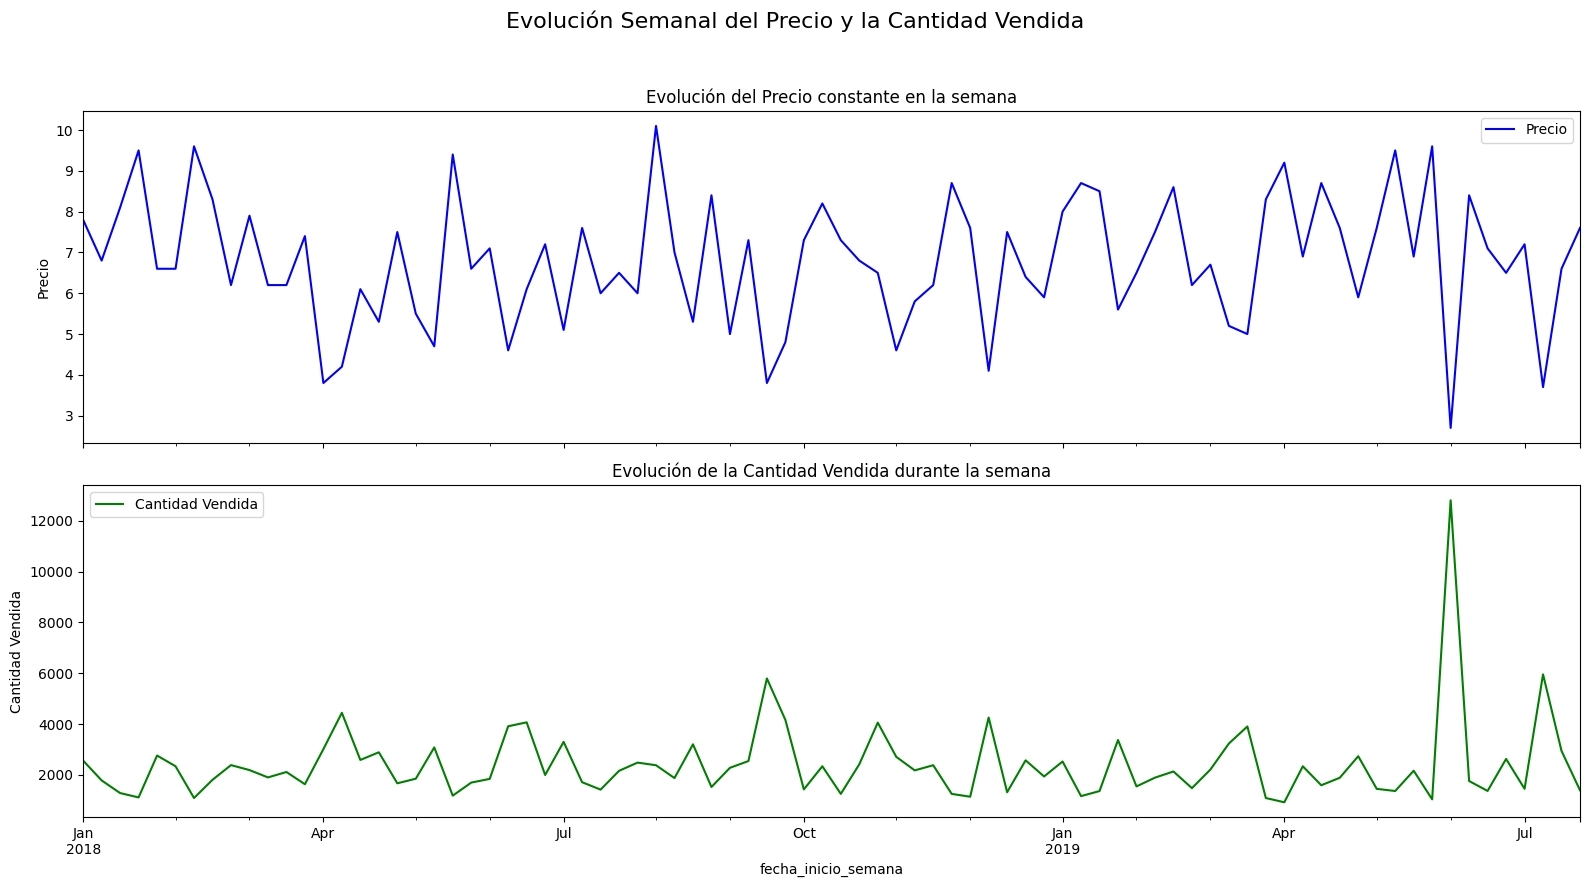

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 9), sharex=True)

weekly_data.set_index('fecha_inicio_semana')['precio'].plot(
    ax=axes[0], color='blue', label='Precio')
axes[0].set_title('Evolución del Precio constante en la semana')
axes[0].set_ylabel('Precio')
axes[0].legend()

weekly_data.set_index('fecha_inicio_semana')['cantidad'].plot(
    ax=axes[1], color='green', label='Cantidad Vendida')
axes[1].set_title('Evolución de la Cantidad Vendida durante la semana')
axes[1].set_ylabel('Cantidad Vendida')
axes[1].legend()

fig.suptitle('Evolución Semanal del Precio y la Cantidad Vendida', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Deja espacio para el título principal
plt.show()

## Relación entre cantidad y precio

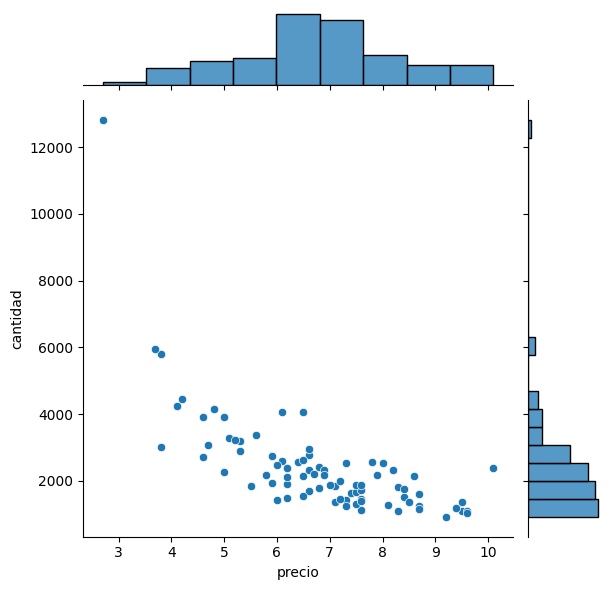

In [13]:
sns.jointplot(weekly_data,x='precio',y='cantidad')

## Modelos de demanda

### Ecuación de la demanda lineal
La forma general de una función de demanda lineal es:

$$
Q = a - bP
$$

Donde:
- $Q$: Cantidad demandada.
- $P$: Precio del bien.
- $a$: Intersección con el eje de cantidad (demanda máxima cuando el precio es 0).
- $b$: Pendiente de la curva de demanda (cambio en $Q$ ante un cambio en $P$).



#### Estimando el modelo

In [14]:
elast_var = smf.ols(formula='cantidad ~ precio', data=weekly_data).fit()

In [15]:
print(elast_var.summary())

                            OLS Regression Results                            
Dep. Variable:               cantidad   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     74.15
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           5.11e-13
Time:                        18:26:30   Log-Likelihood:                -691.18
No. Observations:                  82   AIC:                             1386.
Df Residuals:                      80   BIC:                             1391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7074.3059    556.759     12.706      0.0

#### **Cálculo de la elasticidad precio de la demanda**
La elasticidad precio de la demanda $(E_p)$ se define como el cambio porcentual en la cantidad demandada dividido por el cambio porcentual en el precio:

$$
E_p = \frac{\partial Q}{\partial P} \cdot \frac{P}{Q}
$$

Sustituyendo la ecuación de la demanda lineal $Q = a - bP$:
1. **Derivada parcial de $Q$ con respecto a $P$:**  
   $$
   \frac{\partial Q}{\partial P} = -b
   $$

2. **Sustituyendo en la fórmula de $E_p$:**
   $$
   E_p = -b \cdot \frac{P}{Q}
   $$

3. **Sustituyendo $Q = a - bP$:**
   $$
   E_p = -b \cdot \frac{P}{a - bP}
   $$


### Ecuación de demanda logaritmica

#### **Ecuación de la demanda log-log**
En un modelo log-log, la relación entre la cantidad demandada ($Q$) y el precio ($P$) es:

$$
\ln(Q) = \alpha + \beta \ln(P)
$$

Donde:
- $\ln$: Logaritmo natural.
- $\alpha$: Intercepto (constante del modelo).
- $\beta$: Coeficiente de elasticidad precio de la demanda.

In [16]:
elast_cte = smf.ols(formula='np.log(cantidad) ~ np.log(precio)', data=weekly_data).fit()

In [17]:
print(elast_cte.summary())

                            OLS Regression Results                            
Dep. Variable:       np.log(cantidad)   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     164.5
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           4.24e-21
Time:                        18:26:30   Log-Likelihood:                -6.1100
No. Observations:                  82   AIC:                             16.22
Df Residuals:                      80   BIC:                             21.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.4807      0.222     47.

#### **Cálculo de elasticidad**
La elasticidad precio de la demanda ($E_p$) en el modelo log-log es simplemente igual al coeficiente $\beta$:

$$
E_p = \beta
$$

Esto ocurre porque el modelo log-log implica que los cambios porcentuales en $Q$ son proporcionales a los cambios porcentuales en $P$. Es decir:

$$
\frac{\Delta Q / Q}{\Delta P / P} = \beta
$$

### **Interpretación del coeficiente de elasticidad**
El valor de $E_p$ depende del precio $P$:
- Si $E_p < -1$: Demanda elástica (la cantidad responde más que proporcionalmente al cambio en precio).
- Si $E_p = -1$: Elasticidad unitaria (ingresos máximos).
- Si $-1 < E_p < 0$: Demanda inelástica (la cantidad responde menos que proporcionalmente al cambio en precio).

### Comparando modelos

In [18]:
# Obtener R²
r2_linear = elast_var.rsquared
r2_loglog = elast_cte.rsquared

In [19]:
range_price = np.arange(2.5,10.1,0.1)
price_data = pd.DataFrame({'precio': range_price})
price_data['elast_var'] = elast_var.predict(price_data)
price_data['elast_cte'] = np.exp(elast_cte.predict(price_data))
price_data.sort_values('precio',inplace=True)

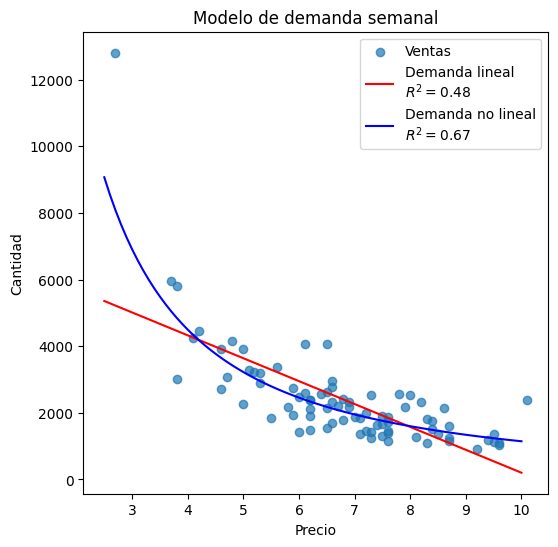

In [20]:
# Gráficos
plt.figure(figsize=(6, 6))
plt.scatter(weekly_data['precio'], weekly_data['cantidad'], label='Ventas', alpha=0.7)
plt.plot(price_data['precio'], price_data['elast_var'], color='red', label=f'Demanda lineal\n$R^2={r2_linear:.2f}$')
plt.plot(price_data['precio'], price_data['elast_cte'], color='blue', label=f'Demanda no lineal\n$R^2={r2_loglog:.2f}$')
plt.xlabel('Precio')
plt.ylabel('Cantidad')
plt.title('Modelo de demanda semanal')
plt.legend()
plt.show()

## Comparando elasticidades

In [21]:
range_price = np.arange(2.5,9,0.1)

In [22]:
range_price_df = pd.DataFrame({'precio': range_price})

# Predicciones de cantidad
predicted_quantity = elast_var.predict(range_price_df)

# Elasticidad precio de la demanda
range_price_df['elasticity'] = elast_var.params['precio'] * (range_price / predicted_quantity)

In [23]:
# Encontrar el índice del valor más cercano a 1 en la columna 'elasticity'
closest_to_zero_index = (range_price_df['elasticity'] + 1).abs().idxmin()

# Obtener el precio y la elasticidad correspondientes
closest_price = range_price_df.loc[closest_to_zero_index, 'precio']
closest_elasticity = range_price_df.loc[closest_to_zero_index, 'elasticity']

# Mostrar los resultados
print(f"El precio más cercano a elasticidad = 1 es {closest_price:.2f}, con una elasticidad de {closest_elasticity:.6f}")

El precio más cercano a elasticidad = 1 es 5.10, con una elasticidad de -0.982323


In [24]:
cte_elasticity = elast_cte.params['np.log(precio)']
print(f"La elasticidad constante en el modelo log log es: {cte_elasticity:.1f}")

La elasticidad constante en el modelo log log es: -1.5


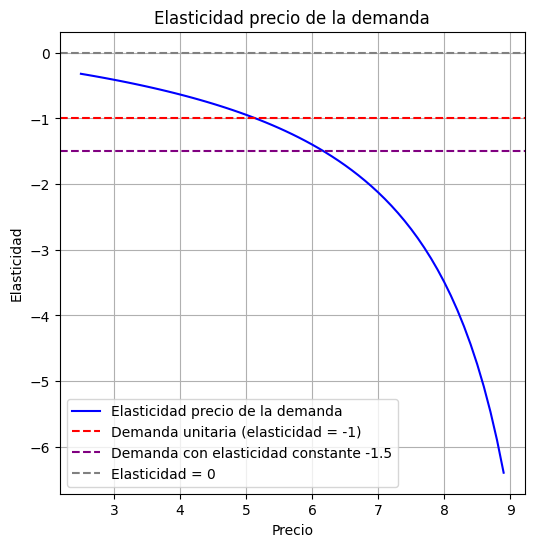

In [25]:
plt.figure(figsize=(6, 6))
plt.plot(range_price, range_price_df['elasticity'], label='Elasticidad precio de la demanda', color='blue')
plt.axhline(y=-1, color='red', linestyle='--', label='Demanda unitaria (elasticidad = -1)')
plt.axhline(y=cte_elasticity, color='purple', linestyle='--', label=f'Demanda con elasticidad constante {cte_elasticity:.1f}')
plt.axhline(y=0, color='gray', linestyle='--', label='Elasticidad = 0')
plt.title('Elasticidad precio de la demanda')
plt.xlabel('Precio')
plt.ylabel('Elasticidad')
plt.legend()
plt.grid()
plt.show()

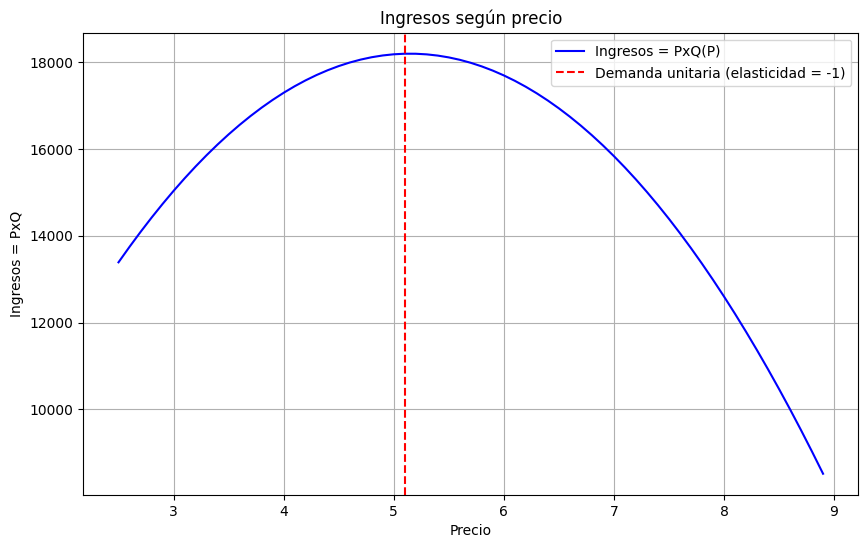

In [26]:
ingresos = range_price * predicted_quantity
plt.figure(figsize=(10, 6))
plt.plot(range_price, ingresos, label='Ingresos = PxQ(P)', color='blue')
plt.axvline(x=closest_price, color='red', linestyle='--', label='Demanda unitaria (elasticidad = -1)')
plt.title('Ingresos según precio')
plt.xlabel('Precio')
plt.ylabel('Ingresos = PxQ')
plt.legend()
plt.grid()
plt.show()

## conclusión

- Modelo lineal: Al precio de 5.10, la elasticidad es cercana a -1. Esto significa que para maximizar ingresos, el precio debería ser un poco mayor a 5.10, ya que en el tramo inelástico (elasticidad mayor a -1) subir precios aumenta los ingresos.

- Modelo log-log: Aquí la elasticidad es constante en -1.5, lo que significa que la demanda siempre es elástica. En este caso, bajar precios siempre incrementará los ingresos, ya que los consumidores son muy sensibles a los cambios de precio.